<a href="https://colab.research.google.com/github/vongkhmer/AI_Paper_Implementation/blob/main/style_transfer_with_VGG_by_vongkh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

device = torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
print(device)

cuda


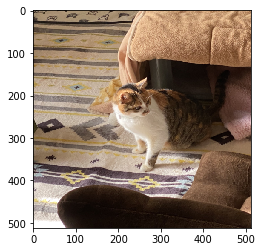

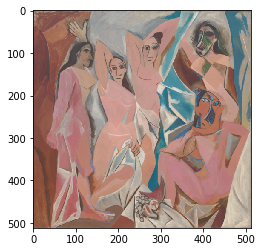

In [2]:
#upload yor own photo and change the file name to the appropriate one in the code
original_img = Image.open("my_cat.jpeg")
style_img = Image.open("picasso3.jpeg")

def transform_image(img, size):
  loader=transforms.Compose([transforms.Resize((size,size)), transforms.ToTensor()])
  return loader(img).unsqueeze(0).to(device)

def show_tensor_img(img):
  npimg = img.cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
  plt.show()

original_img = transform_image(original_img, 512)
style_img = transform_image(style_img, 512)
show_tensor_img(original_img.squeeze())
show_tensor_img(style_img.squeeze())

In [3]:
pretrained_vgg_19 = models.vgg19(pretrained=True)
vgg_feature = (list(pretrained_vgg_19.children())[0])
vgg_feature.to(device)
print(vgg_feature)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [4]:
def extract_feature_vector(x, model, extract_layers):
  feature_vectors = []
  for layer_num, layer in enumerate(model):
    x = layer(x)
    if layer_num in extract_layers:
      feature_vectors.append(x)
  return feature_vectors

def layer_content_loss(original_layer , generated_layer):
    return torch.mean((original_layer - generated_layer)**2)

def layer_style_loss(style_layer, generated_layer):

    batch_size, channel, height, width = style_layer.shape

    G=torch.mm(generated_layer.view(channel,height*width),generated_layer.view(channel,height*width).t())

    A=torch.mm(style_layer.view(channel,height*width),style_layer.view(channel,height*width).t())

    return torch.mean((G - A) ** 2)



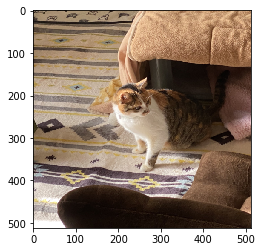

In [5]:
generated_img = original_img.clone().requires_grad_(True)
show_tensor_img(generated_img.cpu().squeeze().detach())

In [6]:
results = []
EPOCH_NUM= 500
#Feel free to tune the hyperparameter
lr=0.004
alpha= 1
beta= 100
extract_layers = [0,5,10,19,28] 
optimizer=optim.Adam([generated_img], lr=lr)


for epoch in range(EPOCH_NUM):
  original_features = extract_feature_vector(original_img, vgg_feature, extract_layers)
  style_features = extract_feature_vector(style_img, vgg_feature, extract_layers)
  generated_features = extract_feature_vector(generated_img, vgg_feature, extract_layers)
  total_loss = 0
  for x, y, z in zip(original_features, generated_features, style_features):
    total_loss += alpha * layer_content_loss(x, y) + beta * layer_style_loss(y, z)

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  if epoch % 20 == 0:
    print(f"epoch {epoch} loss {total_loss}")
    save_image(generated_img,"gen_epoch_" + str(epoch) + ".png")    

    results.append(generated_img.clone().detach())

epoch 0 loss 8702181376.0
epoch 20 loss 1061975424.0
epoch 40 loss 372545504.0
epoch 60 loss 210037728.0
epoch 80 loss 150720032.0
epoch 100 loss 120152200.0
epoch 120 loss 101273928.0
epoch 140 loss 88228200.0
epoch 160 loss 78551280.0
epoch 180 loss 71026656.0
epoch 200 loss 65004420.0
epoch 220 loss 60069988.0
epoch 240 loss 55943996.0
epoch 260 loss 52424464.0
epoch 280 loss 49390672.0
epoch 300 loss 46736972.0
epoch 320 loss 44402716.0
epoch 340 loss 42324328.0
epoch 360 loss 40463820.0
epoch 380 loss 38785844.0
epoch 400 loss 37263580.0
epoch 420 loss 35872532.0
epoch 440 loss 34598324.0
epoch 460 loss 33425934.0
epoch 480 loss 32345700.0


In [9]:
#create some animation
save_image(original_img, "original.png")
images = [Image.open("original.png")]
for e in range(0, EPOCH_NUM, 20):
  fn = "gen_epoch_"+ str(e) +".png"
  images.append(Image.open(fn))

images[0].save('generated_img_animated.gif', save_all=True, append_images=images[1:], duration=100, loop=0)
